# note-1-train-and-test
This notebook is for main task of training and testing the model. 
It loads the pre-trained model and train it on the MNIST dataset.

## Flow
1. Setup the environment
1. Train the model
1. Test the model


## Step

### 1. Setup the environment
#### Install the dependencies

In [1]:
!pip install --quiet --upgrade pip
!pip install --quiet -r requirements.txt

#### Import the libraries and set the environment variables

In [2]:
import os
import matplotlib.pyplot as plt
import torch, torchvision, torchsummary

# Config
FORCE_CPU = True
FREEZE_RESNET = False
CHANNEL_SIZE = 3
RESIZE_SIZE = (224, 224)

NORMALIZE_MEAN = (0.5,0.5,0.5)
NORMALIZE_STD = (0.5,0.5,0.5)

DATA_ROOT_PATH = "./data"
MODEL_ROOT_PATH = "./models"
MODEL_NAME = "pilot"
MODEL_VERSION = "1"

# Hyperparameters
learning_rate = 0.001
momentum = 0.9
num_epochs = 3
batch_size = 100
num_workers = 0 # main process
t_max = 200

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize(RESIZE_SIZE),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x.repeat(CHANNEL_SIZE, 1, 1)),
        torchvision.transforms.Normalize(NORMALIZE_MEAN,NORMALIZE_STD),
    ]
)

if FORCE_CPU:
    device = torch.device("cpu")
    print("CPU is forced. Using CPU.")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("MPS is available and built. Using Apple Silicon GPU.")
else:
    device = torch.device("cpu")
    print("Neither CUDA nor MPS is available or built. Using CPU.")

CPU is forced. Using CPU.


#### Download the dataset

In [3]:
dataset_train = torchvision.datasets.MNIST(root=DATA_ROOT_PATH, train=True, download=True, transform=transform)
dataloader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)

dataset_test = torchvision.datasets.MNIST(root=DATA_ROOT_PATH, train=False, download=True, transform=transform)
dataloader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True, num_workers=num_workers)

#### Show some samples of the dataset

Training Dataset: 60000 samples
Testing Dataset: 10000 samples


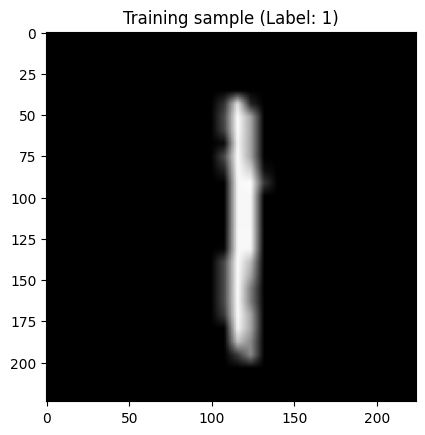

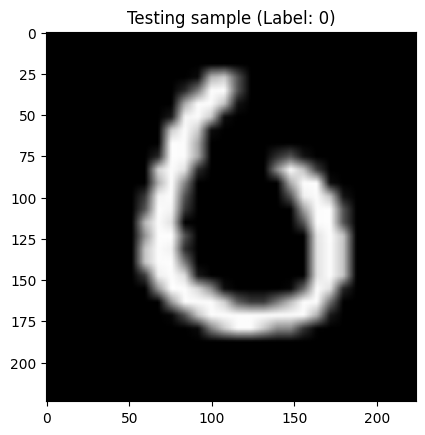

In [4]:
# Dataset Info.
print(f"Training Dataset: {len(dataset_train)} samples")
print(f"Testing Dataset: {len(dataset_test)} samples")

# Visualize a sample
sample_train = next(iter(dataloader_train))
sample_test = next(iter(dataloader_test))

image_train = sample_train[0][0].permute(1, 2, 0) # (C, H, W) -> (H, W, C)
image_train = (image_train + 1) / 2 # Normalize Grayscale to [0, 1]

image_test = sample_test[0][0].permute(1, 2, 0) # (C, H, W) -> (H, W, C)
image_test = (image_test + 1) / 2 # Normalize Grayscale to [0, 1]

plt.imshow(image_train)
plt.title(f"Training sample (Label: {sample_train[1][0]})")
plt.show()

plt.imshow(image_test)
plt.title(f"Testing sample (Label: {sample_test[1][0]})")
plt.show()

### 2. Train the model

#### Define the training function

In [5]:
def train_model(
    model : torch.nn.Module,
    dataloader : torch.utils.data.DataLoader,
    criterion : torch.nn.Module,
    optimizer : torch.optim.Optimizer,
    show_progress : bool = True,
    epoch : int = 0,
    num_epochs : int = 0,
):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        predicted = torch.max(outputs.data, 1)[1]
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # if show_progress:
        #     print(f"  -- batch [Partial Loss: {loss.item():.4f}, Partial Accuracy: {100*correct/total:.1f}%]")

    total_loss = train_loss / total
    total_acc = correct / total

    if show_progress:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {100*total_acc:.1f}%")

    return total_loss, total_acc

#### Load and set the model
Load the pre-trained model and set the parameters to be trained.

In [6]:
model = torchvision.models.resnet18(
    weights = torchvision.models.resnet.ResNet18_Weights.IMAGENET1K_V1
)

if FREEZE_RESNET:
    for name, param in model.named_parameters():
        # Freeze the parameters
        param.requires_grad = False

# Fine-tune the fully connected layer
model.fc = torch.nn.Linear(model.fc.in_features, len(dataset_train.classes))
model = model.to(device)

model_config_pbtxt = f"""
name: "{MODEL_NAME}-{device.type}"
platform: "pytorch_libtorch"
max_batch_size: 8
input [
    {{
        name: "x.1"
        data_type: TYPE_FP32
        dims: [ {CHANNEL_SIZE}, {RESIZE_SIZE[0]}, {RESIZE_SIZE[1]} ]
    }}
]
output [
    {{
        name: "4"
        data_type: TYPE_FP32
        dims: [ {len(dataset_train.classes)} ]
    }}
]
"""

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    params = model.parameters(),
    lr = learning_rate,
    momentum = momentum,
)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=t_max)

#### Do train the model

Considerations:
- Just use SGD(Stochastic Gradient Descent)
- No training record
- No early stopping

In [7]:
for epoch in range(num_epochs):
    train_model(model, dataloader_train, criterion, optimizer, show_progress=True, epoch=epoch, num_epochs=num_epochs)

Epoch [1/3], Loss: 0.1858, Accuracy: 96.0%
Epoch [2/3], Loss: 0.0317, Accuracy: 99.2%
Epoch [3/3], Loss: 0.0209, Accuracy: 99.5%


## Save Model

In [8]:
torchsummary.summary(
    model = model,
    input_size = (CHANNEL_SIZE, RESIZE_SIZE[0], RESIZE_SIZE[1]),
    device = device.type
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

Convert the model to TorchScript, and check the graph of model.

expected graph:
```
graph(%self.1 : __torch__.torchvision.models.resnet.ResNet,
      %x.1 : Tensor):
  %4 : Tensor = prim::CallMethod[name="_forward_impl"](%self.1, %x.1)
  return (%4)
```

- Input: x.1
- Output: 4

In [9]:
model_scripted = torch.jit.script(model)
print(model_scripted.graph)

graph(%self : __torch__.torchvision.models.resnet.ResNet,
      %x.1 : Tensor):
  %3 : Tensor = prim::CallMethod[name="_forward_impl"](%self, %x.1) # /Users/jyje/.pyenv/versions/3.12.8/envs/pilot-mlops-cicd-poc/lib/python3.12/site-packages/torchvision/models/resnet.py:285:15
  return (%3)



In [10]:
if not os.path.exists(f"{MODEL_ROOT_PATH}/{MODEL_NAME}-{device.type}/{MODEL_VERSION}"):
    os.makedirs(f"{MODEL_ROOT_PATH}/{MODEL_NAME}-{device.type}/{MODEL_VERSION}")

model_path = f"{MODEL_ROOT_PATH}/{MODEL_NAME}-{device.type}/{MODEL_VERSION}/model.pt"
model_scripted.save(model_path)

# Save the model configuration
with open(f"{MODEL_ROOT_PATH}/{MODEL_NAME}-{device.type}/config.pbtxt", "w") as f:
    f.write(model_config_pbtxt)

## Load Model

In [11]:
loaded_model = torch.jit.load(f"{MODEL_ROOT_PATH}/{MODEL_NAME}-{device.type}/{MODEL_VERSION}/model.pt")
loaded_model.eval()
loaded_model = loaded_model.to(device)

# # Not working... (torchsummary does not support TorchScript)
# torchsummary.summary(
#     model = loaded_model,
#     input_size = (CHANNEL_SIZE, RESIZE_SIZE[0], RESIZE_SIZE[1]),
#     device = device.type
# )

## Test Model

tensor([[ 7.0855, -1.3004, -0.6032, -2.2854, -1.7655,  0.0332,  0.1337, -1.5946,
         -0.4349,  1.8272]], grad_fn=<AddmmBackward0>)


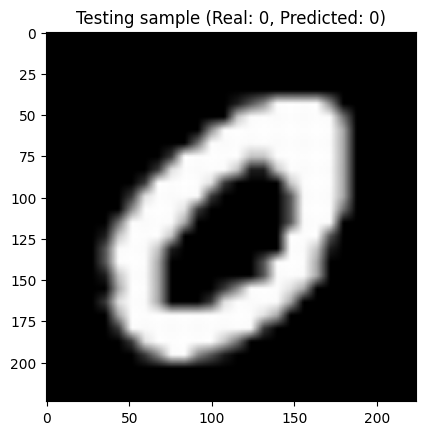

Predicted Number: 0
Probability Distribution:
 - Number 0: 99.14%
 - Number 1: 0.02%
 - Number 2: 0.05%
 - Number 3: 0.01%
 - Number 4: 0.01%
 - Number 5: 0.09%
 - Number 6: 0.09%
 - Number 7: 0.02%
 - Number 8: 0.05%
 - Number 9: 0.52%


In [12]:
# Visualize a sample
sample_test = next(iter(dataloader_test))

img_test = sample_test[0][0].permute(1, 2, 0) # (C, H, W) -> (H, W, C)
img_test = (img_test + 1) / 2 # Normalize Grayscale to [0, 1]

test_img = img_test.permute(2, 0, 1).unsqueeze(dim=0).to(device)  # (H,W,C) -> (1,C,H,W)
response = loaded_model(test_img)
print(response)
probabilities = torch.nn.functional.softmax(response, dim=1)
predicted_class = torch.argmax(probabilities).item()

plt.imshow(img_test)
plt.title(f"Testing sample (Real: {sample_test[1][0]}, Predicted: {predicted_class})")
plt.show()

print(f"Predicted Number: {predicted_class}")
print(f"Probability Distribution:")
for idx, prob in enumerate(probabilities[0]):
    print(f" - Number {idx}: {prob.item()*100:.2f}%")